# A TUTORIAL ON BINARY LOGISTIC REGRESSION

by Sebastian T. Glavind, September, 2022

In [1]:
import numpy as np
import math
import scipy.stats as ss
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
# import seaborn as sns
# import pickle
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

# The model

In binary logistic regression, the scalar output $y \in \{0,1\}$ is assumed to follow a Bernoulli distribution defined as 
$$
y|\mathbf{w}, \mathbf{x} \sim \text{Ber}\left( g(z) \right), \quad \text{where} \quad z = \mathbf{w}^T \mathbf{x} = w_0 + \sum_{m=1}^M w_m x_m \quad \text{and} \quad g(z) = p(y=1|z) = \frac{1}{1+\exp(-z)}. 
$$
Here, $g$ is the sigmoid function, $\mathbf{x}=(1,x_1, x_2, ..., x_{M-1})^T$ is an augmented input vector with an additional first element that is alway 1, and $\mathbf{w}=(w_0,w_1,w_2, w_{M-1})^T$ is the corresponding weight vector. Note the sigmoid function is illustrated below.

If we now consider a training data set $\mathcal{D}=\{ \mathbf{x}[n], y[n] \}_{n=1}^N = \{ \mathbf{X}, \mathbf{y} \}$, where $\mathbf{X}$ is a $N \times M$ design matrix and $\mathbf{y}$ is a column vector of the corresponding output observations, the joint likelihood of the training data may be written:
$$ 
\mathbf{y} | \mathbf{w}, \mathbf{X} \sim \prod_{n=1}^N \text{Ber}\left( g(z[n]) \right), \quad \text{where} \quad z[n] = \mathbf{w}^T \mathbf{x}[n]. 
$$
Thus, the likelihood decomposes into a product in the individual likelihoods, see Murphy (2022; ch. 10) for further details.

------------------

Murphy, Kevin P. Probabilistic machine learning: an introduction. MIT press, 2022.

------------------

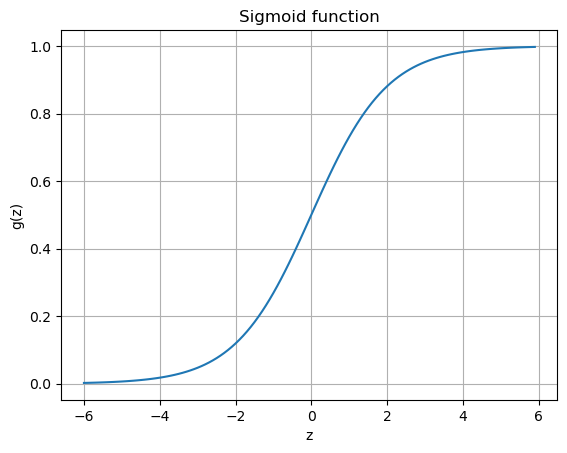

In [2]:
def sigmoid(z):
    """
    Compute the sigmoid of z.
    Args:
        z (ndarray): A scalar, numpy array of any size.
    Returns:
        g (ndarray): sigmoid(z), with the same shape as z   
    """    
    g = 1/(1+np.exp(-z))    
    
    return g

def plot_sigmoid(x=np.arange(-6,6,0.1)):
    plt.plot(x,sigmoid(x))
    plt.title('Sigmoid function')
    plt.xlabel('z')
    plt.ylabel('g(z)')
    plt.grid()
    plt.show()
    
plot_sigmoid()

# Sample data

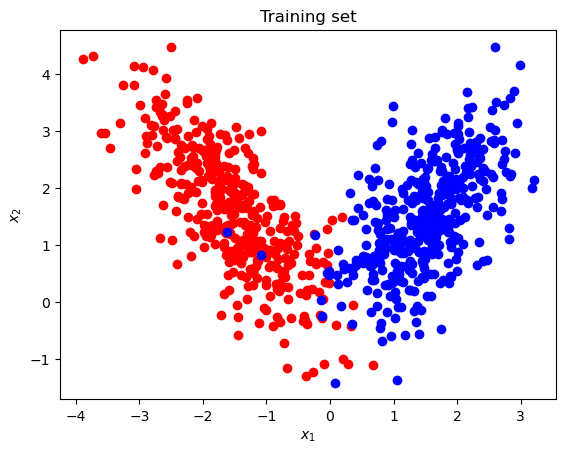

In [3]:
# Generate data
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, class_sep=1.5, weights=[0.5,0.5], random_state=0)

# Split into training and test set
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, train_size=.8, shuffle=True, random_state=1)
Ntr = Xtrain.shape[0]
Nte = Xtest.shape[0]

# Standardize features
scaler = StandardScaler()
scaler.fit(Xtrain)
sXtrain = scaler.transform(Xtrain)
sXtest = scaler.transform(Xtest)

# Augmented, standardized features
aXtrain = np.hstack([np.ones(Ntr).reshape(-1,1), sXtrain])
aXtest = np.hstack([np.ones(Nte).reshape(-1,1), sXtest])
M = aXtrain.shape[1]

plt.plot(Xtrain[ytrain==0,0], Xtrain[ytrain==0,1], 'ro')
plt.plot(Xtrain[ytrain==1,0], Xtrain[ytrain==1,1], 'bo')
plt.title('Training set')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

# Maximum likelihood estimation

The training set likelihood as shown above can be expanded as follows:
$$
p(\mathbf{y} | \mathbf{w}, \mathbf{X}) = \prod_{n=1}^N \text{Ber}\left( g(z[n]) \right) = \prod_{n=1}^N g(z[n])^{y[n]} \times (1 - g(z[n]))^{(1-y[n])}.
$$
It is usually more convenient to work with the logarithm of the likelihood when fitting a model; the log-likelihood of the data takes the following form:
$$
\log p(\mathbf{y} | \mathbf{w}, \mathbf{X}) = \log \prod_{n=1}^N g(z[n])^{y[n]} \times (1 - g(z[n]))^{(1-y[n])} = \sum_{n=1}^N y[n] \log g(z[n]) + (1-y[n]) \log (1 - g(z[n])) = - \sum_{n=1}^N \mathbb{H}(y[n], g(z[n])),
$$
where $\mathbb{H}(p,q) = - \left[ p \log q + (1-p) \log (1-q) \right]$ is the so-called cross-entropy between distribution $p$ and $q$. In the optimization literature, it is more common to minimize an objective function rather than maximizing a likelihood function. Thus, we will thus do the same and minimize the negative log-likelihood (scaled by the training set size):
$$
\text{NLL}(\mathbf{w}) = - \frac{1}{N} \sum_{n=1}^N \left[ y[n] \log g(z[n]) + (1-y[n]) \log (1 - g(z[n])) \right]
$$
Please refer to Murphy(2022; ch. 10) for further details.

In [4]:
def loglike(X,y,w):
    N = X.shape[0] 
    ll_sum = 0.
    for i in range(N):
        z_i = np.dot(X[i], w) 
        g_i = sigmoid(z_i)                                   
        ll_sum +=  y[i]*np.log(g_i) + (1-y[i])*np.log(1-g_i)
    return(ll_sum)
    
def compute_cost(X,y,w,lambda_= None): # lambda_: unused placeholder (included later for regularization)
    """
    Computes the negative log-likelihood cost over all examples
    """
    
    N = X.shape[0] 
    ll_sum = loglike(X,y,w)
    nll_scaled = - ll_sum / N
    return(nll_scaled)

# loglike(aXtrain,ytrain,np.ones(3))
# compute_cost(aXtrain,ytrain,np.ones(3))

To find the maximum likelihood estimate (MLE), we have to solve
$$
\nabla_{\mathbf{w}} \text{NLL}(\mathbf{w}) = 0,
$$
which for this case result in the global minimum, as the objective function can be shown to be convex, see Murphy (2022; ch. 10). However, unlike linear regression, we can no longer write down the MLE in closed form. Instead, we
need to use an optimization algorithm to compute it, see Murphy (2012; ch. 8). We can use any gradient-based optimization algorithm to solve the equation above, e.g., batch gradient decent as discussed in the next section, but in order to do so, we need the gradients of the objective function with respect to the parameters, which we now find.
$$
\begin{align}
\nabla_{\mathbf{w}} \text{NLL}(\mathbf{w}) &= \frac{\partial}{\partial \mathbf{w}} \left[ - \frac{1}{N} \sum_{n=1}^N \left[ y[n] \log g(z[n]) + (1-y[n]) \log (1 - g(z[n])) \right] \right] \\
&= - \frac{1}{N} \sum_{n=1}^N \left[ \underbrace{\frac{\partial}{\partial \mathbf{w}} \left[ y[n] \log g(z[n]) \right]}_{1.} + \underbrace{\frac{\partial}{\partial \mathbf{w}} \left[ (1-y[n]) \log (1 - g(z[n])) \right]}_{2.} \right]
\end{align}
$$

Exercising the chain rule of differentiation on the two parts above in turn, we arrive at 

1. $y[n] \frac{\partial}{\partial \mathbf{w}} \log g(\mathbf{w}^T \mathbf{x}[n]) = y[n] \frac{1}{g(.)} \frac{\partial}{\partial \mathbf{w}} g(\mathbf{w}^T \mathbf{x}[n]) = y[n] \frac{1}{g(.)} g(.) (1 - g(.)) \frac{\partial}{\partial \mathbf{w}} \left( \mathbf{w}^T \mathbf{x}[n] \right) = \underline{y[n] (1 - g(.)) \mathbf{x}[n]} \quad \text{where} \quad g(.) = g(\mathbf{w}^T \mathbf{x}[n])$.

2. $(1-y[n]) \frac{\partial}{\partial \mathbf{w}} \log (1 - g(\mathbf{w}^T \mathbf{x}[n])) = (1-y[n]) \frac{1}{(1 - g(.))} \frac{\partial}{\partial \mathbf{w}} (1 - g(\mathbf{w}^T \mathbf{x}[n])) = (1-y[n]) \frac{1}{(1 - g(.))} \left(- g(.) (1-g(.)) \right) \frac{\partial}{\partial \mathbf{w}} \left( \mathbf{w}^T \mathbf{x}[n] \right) = \underline{- (1-y[n]) g(.) \mathbf{x}[n]}$.

Collectively, this result in the following extression for the gradient:

$$
\begin{align}
\nabla_{\mathbf{w}} \text{NLL}(\mathbf{w}) &= - \frac{1}{N} \sum_{n=1}^N \left[ y[n] (1 - g(.)) \mathbf{x}[n] - (1-y[n]) g(.) \mathbf{x}[n] \right] \\
&= - \frac{1}{N} \sum_{n=1}^N \left[ y[n] \mathbf{x}[n] - g(.) y[n] \mathbf{x}[n] - g(.) \mathbf{x}[n] + y[n] g(.) \mathbf{x}[n] \right] \\
&= - \frac{1}{N} \sum_{n=1}^N (y[n] - g(.)) \mathbf{x}[n] \\
&= \frac{1}{N} \sum_{n=1}^N (g(\mathbf{w}^T \mathbf{x}[n]) - y[n]) \mathbf{x}[n].
\end{align}
$$

Note that $e[n] = g(\mathbf{w}^T \mathbf{x}[n]) - y[n]$ corresponds to the model error in the n'th sample, and thus the gradient weights each input $\mathbf{x}[n]$ by its error and then averages the result. Please refer to Murphy (2022; ch. 10) for further details.

------------------

Murphy, Kevin P. Machine learning: a probabilistic perspective. MIT press, 2012.

------------------

In [5]:
def compute_gradient(X, y, w, lambda_=None): # lambda_: unused placeholder (included later for regularization)
    N, M = X.shape
    dj_dw = np.zeros(w.shape)

    for i in range(N):
        g_i = sigmoid(np.dot(X[i],w))     
        err_i = g_i  - y[i]        
        dj_dw += err_i * X[i] 
    dj_dw = dj_dw/N                                            
    return(dj_dw)

## Batch gradient decent 

Gradient decent is a simple, gradient-based learning algorithm with the following updating scheme: Based on the current parameters setting, take a small step in the direction of steepest decent, wrt. the objective function, when minimizing e.g. the $\text{SSE}$ objective. The updating rule then becomes 

$$ \mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \alpha \nabla_{\mathbf{w}} \text{NLL}(\mathbf{w}), $$

where $\alpha$ is the learning rate. Now in batch gradient decent we use the entire training data set to calculate the gradient at each update. This is in contrast to stochastic gradient decent (SGD), where an update is based on one data point only, and mini-batch SGD, where an update is based on a small subset of the training examples. Note that mini-batch SGD is commonly used to train modern deep-learning applications (Goodfellow et al.,2016). Please refer to e.g., Bishop(2006; Sec. 3.1.3) and Theodoridis(2020; Sec. 5.1 - 5.4) for further details on gradient decent.

***
Bishop, Christopher M. Pattern recognition and machine learning. springer, 2006.

Theodoridis, Sergios. Machine learning: a Bayesian and optimization perspective. Academic Press, 2020.

Goodfellow, I., Bengio, Y., and Courville, A., Deep Learning. MIT Press, 2016, http://www.deeplearningbook.org.
***

In [6]:
def gradient_descent(X, y, w_in, cost_function, gradient_function, alpha, num_iters, lambda_=None):  
    # number of training examples
    N = X.shape[0]
    w = w_in.copy() # do not override global variables
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_dw = gradient_function(X, y, w, lambda_)   

        # Update Parameters using w, b, alpha and gradient
        w -= alpha * dj_dw                            
       
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(X, y, w, lambda_)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w, J_history, w_history #return w and J,w history for graphing

### Perform optimization

In [7]:
# Compute and display cost with w initialized to zeroes
initial_w = np.zeros(M)
print('Cost at initial w (zeros): {:.3f}'.format( compute_cost(aXtrain, ytrain, initial_w)))

Cost at initial w (zeros): 0.693


In [8]:
np.random.seed(42)

# Some gradient descent settings
iterations = 5000
alpha = 0.1

w_gd, J_hist_gd,_ = gradient_descent(aXtrain , ytrain, initial_w, compute_cost, compute_gradient, alpha, iterations)

print('Parameters at final iteration: ', w_gd)

Iteration    0: Cost     0.67   
Iteration  500: Cost     0.10   
Iteration 1000: Cost     0.08   
Iteration 1500: Cost     0.08   
Iteration 2000: Cost     0.07   
Iteration 2500: Cost     0.07   
Iteration 3000: Cost     0.07   
Iteration 3500: Cost     0.07   
Iteration 4000: Cost     0.07   
Iteration 4500: Cost     0.07   
Iteration 4999: Cost     0.07   
Parameters at final iteration:  [0.38852861 6.79415808 0.59004318]


### Analyse results

#### Convergence plot

- We see that the cost decreases at every iteration, which shows that the learning rate is not too large.

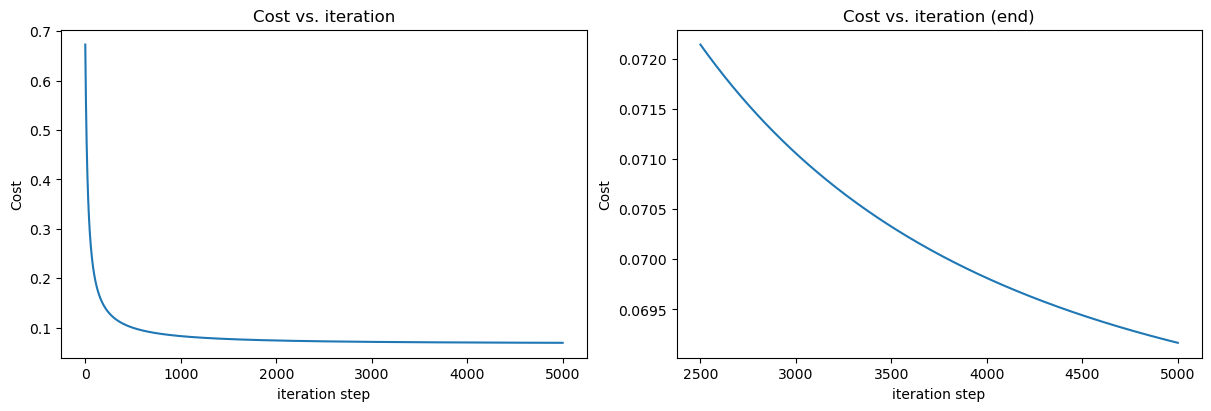

In [9]:
def convergence_plot(J_hist):
    n_J = len(J_hist)
    n_Jhalf = n_J//2
    J_hist_half = J_hist[n_Jhalf:]
    # plot cost versus iteration  
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12,4))
    ax1.plot(J_hist)
    ax2.plot(n_Jhalf + np.arange(n_Jhalf), J_hist_half)
    ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (end)")
    ax1.set_ylabel('Cost')            ;  ax2.set_ylabel('Cost') 
    ax1.set_xlabel('iteration step')  ;  ax2.set_xlabel('iteration step') 
    plt.show()

convergence_plot(J_hist_gd)

#### Decision boundery

- We see a reasonable seperation of classes

In [10]:
# Predict function for hard class assignment
def predict(X, w): 
    N, M = X.shape   
    pred = np.zeros(N)
   
    # Loop over each example
    for i in range(N):   
        z_i = np.dot(X[i], w)                                
        g_i = sigmoid(z_i)                                         
        # Apply the threshold
        pred[i] = (g_i>=0.5)

    return pred

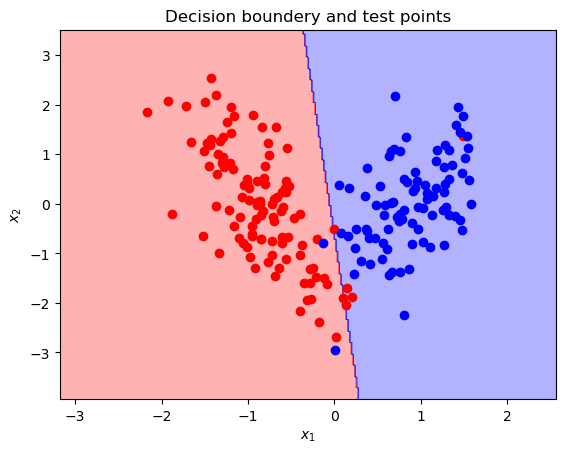

In [11]:
# plot decision boundery
# Adapted from Raschka & Mirjalili (2019; ch. 2; p.34)
def plot_decision_regions(X, y, w, resolution=0.02):
    colors = colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    x2_min, x2_max = X[:, 2].min() - 1, X[:, 2].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = predict(np.array([np.ones(len(xx1.ravel())), xx1.ravel(), xx2.ravel()]).T, w)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # plot samples
    plt.plot(X[y==0,1], X[y==0,2], 'ro')
    plt.plot(X[y==1,1], X[y==1,2], 'bo')
    plt.title('Decision boundery and test points')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.show()
    
plot_decision_regions(aXtest, ytest, w_gd)

---------------------------

Raschka, Sebastian, and Vahid Mirjalili. Python machine learning: Machine learning and deep learning with Python, scikit-learn, and TensorFlow 2. Packt Publishing Ltd, 2019.

--------------------------

## Regularization

A fundamental problem with MLE is that it finds the parameters that minimize cost on the training set, but this may not result in a model that has the lowest cost on future data. This is called overfitting. The main solution to overfitting is to use regularization, which means to add a penalty term to the NLL. Thus, we optimize an objective of the form:
$$
\mathcal{L}(\mathbf{w}; \lambda) = \text{NLL}(\mathbf{w}) + \frac{\lambda}{2 N} C(\mathbf{w}),
$$
where $\lambda \geq 0$ is a regularization parameter, and $C(\mathbf{w})$ is a complexity penalty cost scaled by $2 N$ to normalize the result with respect to the training set size. Note that we also scaled the NLL objective defined earlier. Moreover, the factor 2 is simply a matter of tast depending of the author. A common choise of penalty cost is the $\ell_2$-regularization, also called weight decay or ridge regression, which takes the following form: 
$$
C(\mathbf{w}) = \| \mathbf{w} \|_2^2,
$$
where $\| \mathbf{w} \|_2^2 = \sum_{m=1}^M w_m^2$. Thus, the larger the value of $\lambda$, the more the parameters are penalized for being large, and the less flexible the model becomes. The gradient for this new objective amounts to the gradient of the NLL objective plus an addition regularizarion term, i.e.,
$$
\nabla_{\mathbf{w}} \mathcal{L}(\mathbf{w}) = \frac{\partial}{\partial \mathbf{w}} \text{NLL}(\mathbf{w}) + \frac{\partial}{\partial \mathbf{w}} \frac{\lambda}{2 N} \| \mathbf{w} \|_2^2,
$$
where $\frac{\partial}{\partial \mathbf{w}} \frac{\lambda}{2 N} \| \mathbf{w} \|_2^2 = \frac{\lambda}{N} \sum_{m=1}^M w_m$. We can again use any gradient-based optimization algorithm to solve the following equation:
$$
\nabla_{\mathbf{w}} \mathcal{L}(\mathbf{w}; \lambda) = 0,
$$

e.g., batch gradient decent, as above.

In [12]:
def compute_cost_reg(X, y, w, lambda_ = 1.):
    """
    Computes the regularized negative log-likelihood cost over all examples
    """

    N, M = X.shape
    
    # Calls the compute_cost function that you implemented above
    cost_without_reg = compute_cost(X, y, w) 
    
    # You need to calculate this value
    reg_cost = 0.
    
    for j in range(M):
        reg_cost += (w[j]**2)                                          #scalar
    
    # Add the regularization cost to get the total cost
    total_cost = cost_without_reg + (lambda_/(2 * N)) * reg_cost

    return total_cost

def compute_gradient_reg(X, y, w, lambda_ = 1.): 
    N, M = X.shape
    
    dj_dw = compute_gradient(X, y, w)
    dj_dw += (lambda_/N) * w               
        
    return dj_dw

### Perform optimization

In [13]:
# Compute and display cost with w initialized to zeroes
cost_reg = 1.
print('Cost at initial w (zeros): {:.3f}'.format(compute_cost_reg(aXtrain, ytrain, initial_w, cost_reg)))

Cost at initial w (zeros): 0.693


In [14]:
np.random.seed(42)

# Some gradient descent settings
iterations = 5000
alpha = 0.1

w_gd_reg, J_hist_gd_reg,_ = gradient_descent(aXtrain , ytrain, initial_w, compute_cost_reg, compute_gradient_reg, alpha, iterations, cost_reg)

print('\n Parameters at final iteration: ', w_gd_reg)

Iteration    0: Cost     0.67   
Iteration  500: Cost     0.11   
Iteration 1000: Cost     0.10   
Iteration 1500: Cost     0.10   
Iteration 2000: Cost     0.10   
Iteration 2500: Cost     0.09   
Iteration 3000: Cost     0.09   
Iteration 3500: Cost     0.09   
Iteration 4000: Cost     0.09   
Iteration 4500: Cost     0.09   
Iteration 4999: Cost     0.09   

 Parameters at final iteration:  [0.27537983 5.54954233 0.44701169]


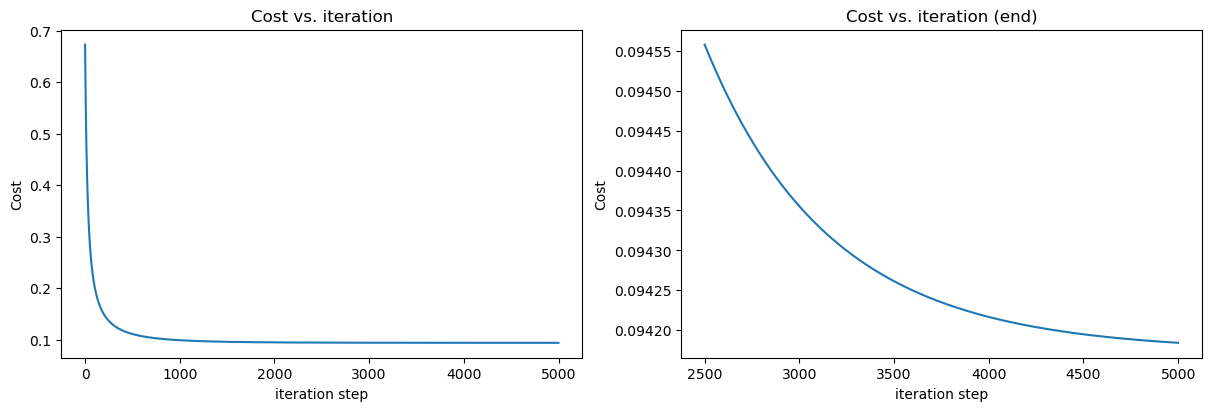

In [15]:
convergence_plot(J_hist_gd_reg)

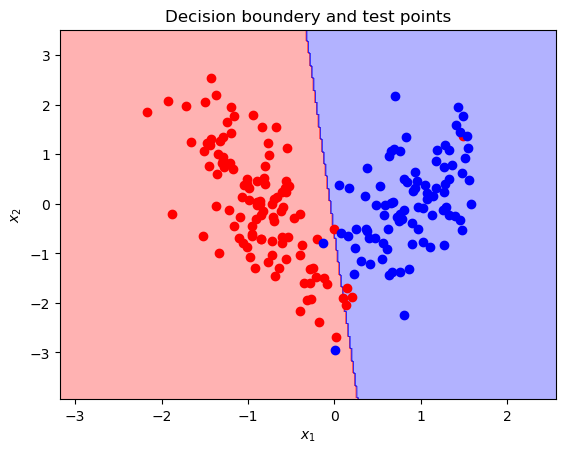

In [16]:
plot_decision_regions(aXtest, ytest, w_gd_reg)

# Bayesian inference

Coming soon.